In [2]:
import os
# os.environ['PYOPENGL_PLATFORM']='osmesa'

import argparse
import pickle
import sys
import cv2
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt
# from gta_utils import LIMBS, read_depthmap
# from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import glob
# from utils import *
import copy
import argparse

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


import sys
sys.path.append('../')
sys.path.append('../../src')

from benji_prox_dataloader import *
from visualisation import *
from utils import *
import tqdm
from simple_transformer import PoseTransformer
import torch
from torch import nn



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


c:\Users\benja\Anaconda3\envs\torch3d\lib\site-packages\tqdm-4.64.0-py3.9.egg\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


numpy: 1.21.5


In [3]:

root_dir = "D:/prox_data"

smplx_model_path='../../models_smplx_v1_1/models/'
in_frames=15
pred_frames=30
frame_jump=10
window_overlap_factor=8
lr = 0.0001
n_iter = 100
batch_size=15

pd = proxDatasetJoints(root_dir=root_dir + '/PROXD_attempt2/PROXD', in_frames=in_frames, pred_frames=pred_frames, \
                       output_type='joint_locations', smplx_model_path=smplx_model_path, frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)
pdc = DatasetBase(root_dir=root_dir + '/recordings', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='Color', extra_prefix='', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)

pd2 = DatasetBase(root_dir=root_dir + '/PROXD_attempt2/PROXD', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='results', extra_prefix='joints_worldnorm.pkl', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)


print(len(pd), len(pdc))
pd.align(pdc)
pdc.align(pd)
print(len(pd), len(pdc))
pd2.align(pd)
pd.align(pd2)
print(len(pd), len(pd2))

# pdi = proxDatasetImages(root_dir="/cluster/scratch/bdayan/prox_data/recordings", in_frames=in_frames, pred_frames=pred_frames)

dataloader = DataLoader(pd, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=my_collate)

1150 1338
1169 1169


In [24]:

root_dir = "D:/prox_data"

smplx_model_path='../../models_smplx_v1_1/models/'
in_frames=15
pred_frames=30
frame_jump=10
window_overlap_factor=8
lr = 0.0001
n_iter = 100
batch_size=15

pd = proxDatasetJoints(root_dir=root_dir + '/PROXD_attempt2/PROXD', in_frames=in_frames, pred_frames=pred_frames, \
                       output_type='joint_locations', smplx_model_path=smplx_model_path, frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)
pdc = DatasetBase(root_dir=root_dir + '/recordings', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='Color', extra_prefix='', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)

pd2 = DatasetBase(root_dir=root_dir + '/PROXD_attempt2/PROXD', in_frames=in_frames, pred_frames=pred_frames,
                                             search_prefix='results', extra_prefix='joints_worldnorm.pkl', frame_jump=frame_jump, window_overlap_factor=window_overlap_factor)


print(len(pd), len(pdc))
pd.align(pdc)
pdc.align(pd)
print(len(pd), len(pdc))
pd2.align(pd)
pd.align(pd2)
print(len(pd), len(pd2))

# pdi = proxDatasetImages(root_dir="/cluster/scratch/bdayan/prox_data/recordings", in_frames=in_frames, pred_frames=pred_frames)

dataloader = DataLoader(pd, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=my_collate)

1150 1338
1169 1169
1169 1169


In [4]:
len(pd)/15

77.93333333333334

In [25]:
pd.output_type = 'joint_locations'
idx, in_joint_locations, pred_joint_locations = pd.__getitem__(500)
pd.output_type = 'raw_pkls'
(idx, (in_joint_fns, in_joint_data), (pred_joint_fns, pred_joint_data)) = pd.__getitem__(500)
in_frames_dicts, in_frames_fns, pred_frames_dicts, pred_frames_fns = pdc.__getitem__(500)
_, in_pkls, _, pred_pkls = pd2.__getitem__(500)
in_skels_pkls, pred_skels_pkls = list(map(load, in_pkls)), list(map(load, pred_pkls))

In [6]:
in_frames = [np.array(cv2.imread(fn)) for fn in in_frames_fns]

In [7]:
in_joint_fns

['D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02224__00.01.14.101\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02234__00.01.14.434\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02244__00.01.14.768\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02254__00.01.15.101\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02264__00.01.15.436\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02274__00.01.15.769\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02284__00.01.16.101\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02294__00.01.16.436\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_00168_01\\results\\s001_frame_02304__00.01.16.770\\000.pkl',
 'D:\\prox_data\\PROXD_attempt2\\PROXD\\MPH8_0

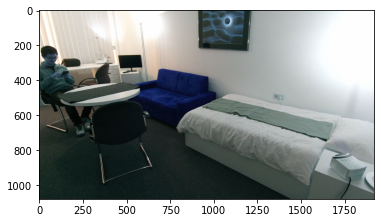

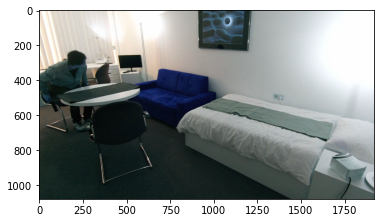

In [8]:
for img in [in_frames[0], in_frames[-1]]:
    _ = plt.figure()
    _ = plt.imshow(img)

In [9]:
def render_mesh_on_image(vertices: np.ndarray, faces: np.ndarray = None, img: np.ndarray = None, mesh_color=(1.0, 1.0, 0.9, 1.0)):
    """
    faces: is None then actually renders points for a skeleton - makes point_size=17.0
    img: background image optional or None otherwise
    """
  
    out_mesh = trimesh.Trimesh(vertices, faces, process=False) if faces is not None else \
        pyrender.Mesh.from_points(vertices, colors=[mesh_color]*len(vertices))


    # common
    H, W = 1080, 1920  # TODO these better be the same as image shape

    r = pyrender.OffscreenRenderer(viewport_width=W,
                            viewport_height=H,
                            point_size=1.0 if faces is not None else 1.0)  # 1.0 too small for skeleton

    camera_center = np.array([951.30, 536.77])  # Idk why these, do be quite close to halfway point
    camera_pose = np.eye(4)
    camera_pose = np.array([1.0, -1.0, -1.0, 1.0]).reshape(-1, 1) * camera_pose
    camera = pyrender.camera.IntrinsicsCamera(
        fx=1060.53, fy=1060.38,
        cx=camera_center[0], cy=camera_center[1])
    light = pyrender.DirectionalLight(color=np.ones(3), intensity=2.0)

    material = pyrender.MetallicRoughnessMaterial(
        metallicFactor=0.0,
        alphaMode='OPAQUE',
        baseColorFactor=mesh_color)
    if faces is not None:
        out_mesh = pyrender.Mesh.from_trimesh(
            out_mesh, material=material)

    ## rendering body
    if img is not None:
        H2, W2, _ = img.shape
        assert(H2 == H and W2 == W)

    scene = pyrender.Scene(bg_color=[0.0, 0.0, 0.0, 0.0],
                        ambient_light=(0.3, 0.3, 0.3))
    scene.add(camera, pose=camera_pose)
    scene.add(light, pose=camera_pose)
    # for node in light_nodes:
    #     scene.add_node(node)

    scene.add(out_mesh, 'mesh')

    body_color, body_depth = r.render(scene)
    body_color = body_color.astype(np.float32)  / 255.0

    # valid_mask = (color[:, :, -1] > 0)[:, :, np.newaxis]
    # input_img = img
    # output_img = (color[:, :, :-1] * valid_mask +
    #               (1 - valid_mask) * input_img)

    valid_mask = (body_color > 0)
    input_img = img if img is not None else np.zeros(body_color.shape)
    output_img = (body_color * valid_mask + (1-valid_mask)*np.flip(input_img, axis=1)/255.0)  # image is reversed for whatever reason

    return body_color, body_depth, output_img

In [8]:
outputs = smplx_and_background_to_video(in_frames, in_joint_data, body_model=pd.body_model, mesh_color=(1.0, 0.3, 0.3, 1.0))

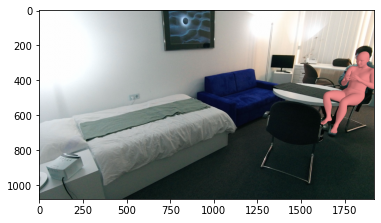

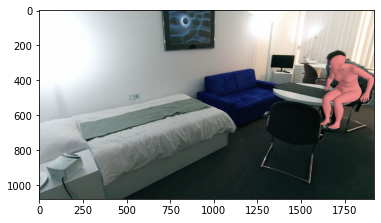

In [9]:
for im in [outputs[0], outputs[-1]]:
    _ = plt.figure()
    _ = plt.imshow(im)

In [10]:
skel1 = in_joint_locations[0].detach().numpy() + in_joint_data[-1]['transl']
body_color, body_depth, output_img = render_mesh_on_image(skel1, faces=None, img = in_frames[0], mesh_color=(0.3, 1.0, 0.3, 1.0))

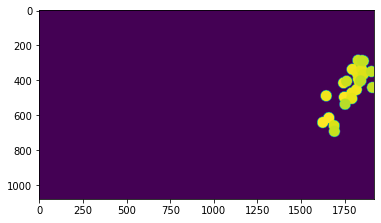

In [11]:
plt.imshow(body_depth)

<Figure size 720x720 with 0 Axes>

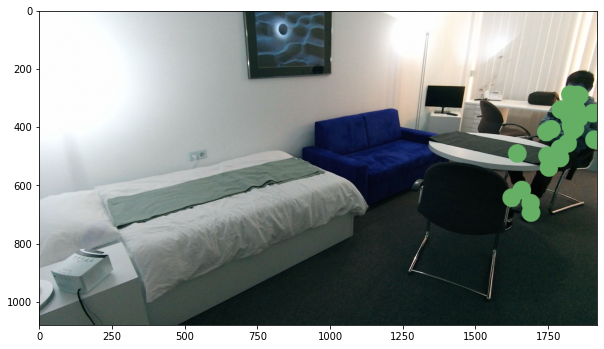

In [12]:
plt.figure(figsize=(10, 10))
plt.imshow(output_img)

In [22]:
def normalized_joint_locations1(data_dict, base_rot_matrix=torch.eye(3).unsqueeze(0), base_transl=torch.zeros(3), body_model=None):
    """normalises wrt rotation and translation. body_model shouldn't be None I'm just lazy."""
    betas, body_pose, euler_angles, transl = extract_data(data_dict)
    transl = transl - base_transl
    euler_angles = normalize_euler_angles(base_rot_matrix, euler_angles)

    out = body_model(return_joints=True, betas=betas, body_pose=body_pose, global_orient=euler_angles, transl=transl)
    joint_locs = out.joints[:, :25]  # 1, 25, 3
    return joint_locs

skel2 = normalized_joint_locations1(in_joint_data[0], body_model=pd.body_model)
skel2.shape
skel1.shape
# skel2.detach().numpy()-skel1  # This is all 0 good

torch.Size([1, 25, 3])

(25, 3)

In [26]:
print(in_joint_fns[0])

D:\prox_data\PROXD_attempt2\PROXD\MPH8_00168_01\results\s001_frame_02224__00.01.14.101\000.pkl


In [30]:
skel_world = in_skels_pkls[0]
import json

with open(root_dir + '/cam2world/MPH8.json') as file:
    cam2world = np.array(json.load(file))
    cam2world = torch.from_numpy(cam2world).float()

skel12world = normalized_joint_locations_world(in_joint_data[0], pd.body_model, cam2world)

In [34]:
torch.all(skel12world - skel_world == 0.)

tensor(True)

In [37]:
skel3 = world2cam(skel_world, cam2world)
torch.max(torch.abs(skel3 - skel2))

tensor(4.7684e-07, grad_fn=<MaxBackward1>)

In [38]:
skel_world.shape

torch.Size([1, 25, 3])

In [18]:
base_euler_angles = torch.Tensor(in_joint_data[0]['global_orient'])
base_rot_matrix = transforms.euler_angles_to_matrix(base_euler_angles, convention='XYZ')
base_rot_matrix.shape

torch.Size([1, 3, 3])

In [19]:
torch.eye(3).unsqueeze(0)

tensor([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]])

<Figure size 720x720 with 0 Axes>

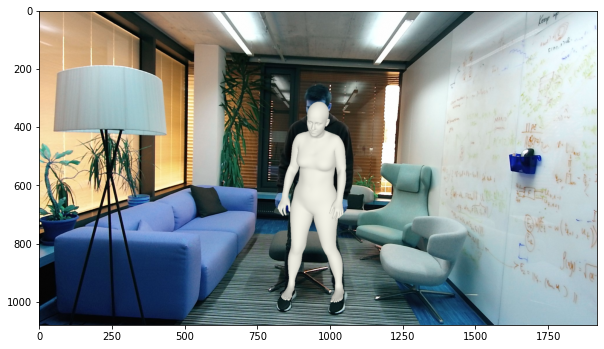

In [108]:
plt.figure(figsize=(10,10))
plt.imshow(output_img)

In [26]:
pd = proxDatasetSkeleton(root_dir=root_dir + '/PROXD', in_frames=in_frames, pred_frames=pred_frames, \
                       output_type='raw_pkls', smplx_model_path=smplx_model_path, frame_jump=frame_jump, window_overlap_factor=window_overlap_factor, extra_prefix='joints_worldnorm.pkl')


In [56]:
def my_collate2(batch):
    # I think these are still np.arrays, will become tensors later
    batch = list(filter(
        # check that they exist and don't have nans??
        lambda triple: (triple[1][1] is not None) and (triple[2][1] is not None),
        batch
    ))
    try:
        return default_collate([(triple[0], torch.stack(triple[1][1]).squeeze(), torch.stack(triple[2][1]).squeeze()) for triple in batch])
    except Exception as e:
        print(f'batch: {[(triple[0], triple[1].shape, triple[2].shape) for triple in batch]}')
        print(e, e.args)
        raise e
        
dataloader = DataLoader(pd, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=my_collate2)

In [79]:
def my_collate2(batch):
    # I think these are still np.arrays, will become tensors later
    
    batch = list(filter(
        # check that they exist and don't have nans??
        lambda triple: (triple[1] is not None) and (triple[2] is not None),
        batch
    ))
    try:
        batch = [(triple[0], torch.stack(triple[1][1]).squeeze(), torch.stack(triple[2][1]).squeeze()) for triple in batch]
    
        batch = list(filter(
            lambda triple: (not torch.any(torch.isnan(triple[1]))) and (not torch.any(torch.isnan(triple[2]))), batch
        ))
        return default_collate(batch)
        
    except Exception as e:
        print(f'batch: {[(triple[0], triple[1].shape, triple[2].shape) for triple in batch]}')
        print(e, e.args)
        raise e
        
dataloader = DataLoader(pd, batch_size=batch_size,
                        shuffle=True, num_workers=0, collate_fn=my_collate2)

In [80]:
(idx, in_skels, fut_skels) = next(iter(dataloader))

In [81]:
batch_size
in_skels.shape
fut_skels.shape

8

torch.Size([8, 15, 25, 3])

torch.Size([8, 30, 25, 3])

In [82]:
pelvis = in_skels[:, 0, 0, :].unsqueeze(1).unsqueeze(1)
in_skels2 = in_skels - pelvis
fut_skels2 = fut_skels - pelvis

In [74]:
fut_skels.shape[1]

30

In [66]:
a = in_skels[:, 0, :].unsqueeze(1).unsqueeze(1)
a.shape

torch.Size([8, 1, 1, 25, 3])

In [43]:
batch = [pd.__getitem__(10) , pd.__getitem__(11)]


In [48]:
default_collate([batch[0][1][1], batch[1][1][1]])

[tensor([[[[ 1.3403, -0.6600, -0.1296],
           [ 1.2946, -0.6208, -0.2256],
           [ 1.3417, -0.7336, -0.2286],
           [ 1.3175, -0.6650, -0.0212],
           [ 1.3369, -0.5578, -0.5976],
           [ 1.4555, -0.7403, -0.5741],
           [ 1.3395, -0.6345,  0.1064],
           [ 1.3154, -0.5917, -0.9936],
           [ 1.3802, -0.7640, -0.9688],
           [ 1.3727, -0.6258,  0.1527],
           [ 1.3941, -0.5156, -1.0729],
           [ 1.4529, -0.7934, -1.0768],
           [ 1.3786, -0.6110,  0.3207],
           [ 1.3621, -0.5712,  0.2303],
           [ 1.3932, -0.6519,  0.2425],
           [ 1.4052, -0.5546,  0.4790],
           [ 1.3105, -0.4754,  0.2893],
           [ 1.4286, -0.7185,  0.3198],
           [ 1.1674, -0.4782,  0.0702],
           [ 1.3967, -0.8889,  0.1155],
           [ 1.2028, -0.3307, -0.1213],
           [ 1.4613, -1.0300, -0.0695],
           [ 1.4005, -0.5690,  0.4780],
           [ 1.4626, -0.5308,  0.5270],
           [ 1.4658, -0.5921,  0.5272]]]

In [35]:
default_collate([(1, np.array([3.5, 2.]), np.arange(3)), (2, np.arange(2), np.arange(3))])

[tensor([1, 2]),
 tensor([[3.5000, 2.0000],
         [0.0000, 1.0000]], dtype=torch.float64),
 tensor([[0, 1, 2],
         [0, 1, 2]])]

In [7]:
import pickle
with open('temp.pkl', 'wb') as file:
    pickle.dump([in_joint_data, in_joint_locations], file)

In [ ]:
skeleton_frames = in_joint_locations.detach().numpy()
trans = np.eye(4)
trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# trans[:3, -1] = np.array([0, 0, -3])
trans[:3, :3] = trans[:3, :3]@rz@rz@rz
trans[:3, -1] = np.array([5, 0, 3])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)

vis.add_geometry(mesh_frame)  

outs = []
for t in range(skeleton_frames.shape[0]):  
    print(t)
    vis.poll_events()
    vis.update_renderer()
    skeleton_input = o3d.geometry.LineSet(
        points=o3d.utility.Vector3dVector(skeleton_frames[t]),
        lines=o3d.utility.Vector2iVector(LIMBS))
    skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

    vis.add_geometry(skeleton_input)

    # ctr = vis.get_view_control()
    # cam_param = ctr.convert_to_pinhole_camera_parameters()
    # cam_param = update_cam(cam_param, trans)
    # ctr.convert_from_pinhole_camera_parameters(cam_param)

    vis.poll_events()
    vis.update_renderer()
    outs.append(np.asarray(vis.capture_screen_float_buffer()))
    vis.remove_geometry(skeleton_input)

True

In [ ]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  

vis.poll_events()
vis.update_renderer()
temp = vis.capture_screen_float_buffer(False)



True

In [4]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  

True

True

In [5]:
vis.poll_events()

True

In [ ]:
plt.imshow(np.asarray(temp))

In [ ]:
mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame) 

vis.poll_events()
vis.update_renderer()

t=3

skeleton_frames = in_joint_locations.detach().numpy()
skeleton_input = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(skeleton_frames[t]),
    lines=o3d.utility.Vector2iVector(LIMBS))
skeleton_input.colors = o3d.utility.Vector3dVector(color_input)

vis.add_geometry(skeleton_input)


vis.poll_events()
vis.update_renderer()
temp = vis.capture_screen_float_buffer(False)


True

In [ ]:
plt.imshow(temp)

In [5]:
skeleton_frames = in_joint_locations.detach().numpy()
trans = np.eye(4)
trans[:3, :3] = np.array([[0, 0, -1], [-1, 0, 0], [0, -1, 0]])
rx = np.array([[1, 0, 0], [0, 0, -1], [0, 1, 0]])
ry = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
rz = np.array([[0, -1, 0], [1, 0, 0], [0, 0, 1]])
# trans[:3, :3] = trans[:3, :3]@rz@rz@rz@ry
# trans[:3, -1] = np.array([0, 0, -3])
trans[:3, :3] = trans[:3, :3]@rz@rz@rz
trans[:3, -1] = np.array([5, 0, 3])

mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=[0, 0, 0])
vis = o3d.visualization.Visualizer()
vis.create_window(visible=False)
vis.add_geometry(mesh_frame)  
temp = vis.capture_screen_float_buffer(False)

False

In [6]:
vis.update_renderer()

In [ ]:
temp = vis.capture_screen_float_buffer(False)

In [8]:
base_euler_angles = in_data['global_orient']

NameError: name 'in_data' is not defined